In [1]:
import os
import subprocess
import numpy as np
import pandas as pd
from astropy.io import fits
import matplotlib.pyplot as plt

In [4]:
# Define the file path (assuming it's in the same directory)
file_name = "/home/supremekai/thesis/J0243_6p6124/NICER_second_run/all_lc_periods_manual_error_from_lc_uncor_bootstrap.csv"

# Read the file, skipping comment lines (starting with ##)
df = pd.read_csv(file_name, sep='\s+', comment="#")

# Display the first few rows to check
print(df.head(45))

# Convert obsID column to string (in case it's read as an integer)
df["LC_File_Path"] = df["LC_File_Path"].astype(str)

    LC_File_Path   Period    Chi-square   Date          PErr        freq
0     6050390227  9.80080  21567.529300  20112  5.970000e-06  102.032487
1     6050390228  9.80070  19102.226560  20113  9.520000e-06  102.033528
2     6050390229  9.80060  31955.076170  20114  2.050000e-06  102.034569
3     6050390230  9.80050  20849.029300  20115  2.400000e-05  102.035610
4     6050390231  9.80040  29042.080080  20116  2.060000e-05  102.036652
5     6050390232  9.80040  69798.812500  20117  5.710000e-06  102.036652
6     6050390233  9.80040  90737.585940  20118  5.330000e-06  102.036652
7     6050390234  9.80030  92500.726560  20119  5.930000e-06  102.037693
8     6050390235  9.80030  66881.742190  20120  4.490000e-06  102.037693
9     6050390236  9.80020  48829.242190  20121  2.500000e-05  102.038734
10    6050390237  9.80010  92739.078130  20122  6.590000e-06  102.039775
11    6050390238  9.80000  80758.914060  20123  4.290000e-06  102.040816
12    6050390239  9.79990  43033.179690  20124  4.1

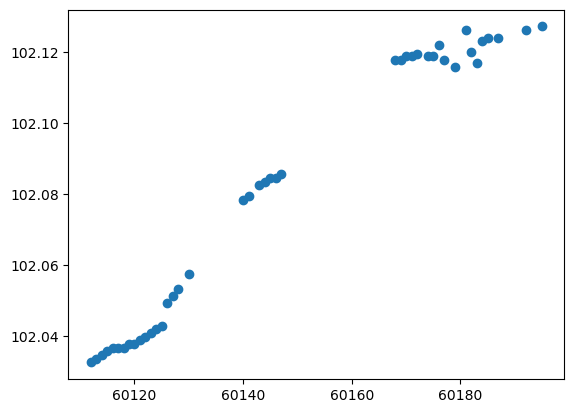

In [7]:
plt.scatter(df['Date']+40000,1000/df['Period'])

In [8]:
# Find all obsID folders in "reduced_output"
obsid_folders = sorted(
    [f.path for f in os.scandir("./reduced_output") if f.is_dir() and f.name.startswith("6050")],
    key=lambda x: int(os.path.basename(x))
)
# Define nphase values (modify if needed)
nphase = 64  # Or adjust based on requirements
epoch='20112.43540056619'

# Loop through each obsID folder
for obsid_folder in obsid_folders:
    obsid = os.path.basename(obsid_folder)
    print(f"Processing obsID: {obsid}")

    # Find the period for this obsID from the DataFrame
    period_row = df[df["LC_File_Path"] == obsid]
    
    if period_row.empty:
        print(f"No period found for obsID: {obsid}, skipping.")
        continue

    period = period_row["Period"].values[0]

    # Find the correct light curve files
    lc_files = []
    for root, dirs, files in os.walk(obsid_folder):
        for file in files:
            if file.endswith("cl_night_barycorr_orbit.evt"):
            #if file.endswith("night_0.1.lc"): ### From LC 
                lc_files.append(os.path.join(root, file))

    if not lc_files:
        print(f"No light curve files found for obsID: {obsid}")
        continue

    print(f"Found {len(lc_files)} light curve files for obsID {obsid} with period {period}.")

    # Define output base directory
    output_base = "./folded_curves"
    os.makedirs(output_base, exist_ok=True)  # Create main output folder if not exists
    # Create obsID-specific output folder
    obsid_output_dir = os.path.join(output_base, obsid)
    os.makedirs(obsid_output_dir, exist_ok=True)

    # Run efold for each LC file
    for lc_file in lc_files:
        light_curve_file = lc_file
        output_profile = os.path.join(obsid_output_dir, f"{obsid}_pulse_profile_lc_files_efold_output_same_epoch.fits")

        print("runs")

        # Constructing the efold command with all required flags
        cmd = (
            f"echo '-' | efold 1 {lc_file} "
            f"outfile={output_profile} "
            f"dper={period} "
            f"nphase={nphase} "
            f"epochfo=1 "
            f"sepoch={epoch} "
            f"nbint=INDEF "
            f"nintfm=INDEF "
            f"plot=no "
            f"norm=0"
        )

        print(f"Running: {cmd}")
        subprocess.run(cmd, shell=True, check=True)
        print(f"Finished processing {lc_file} for obsID {obsid}. Output saved to {output_profile}")
        # Read the output FITS file to check the results            
        with fits.open(output_profile) as hdul:
            # Assuming the first HDU contains the data
            data = hdul[1].data
            print(f"Data from {output_profile}:")
            print(data)
        # Plotting the folded light curve
        plt.figure(figsize=(10, 6))
        plt.plot(data['PHASE'], data['RATE1'], label=f"Folded Light Curve for {obsid}")
        plt.xlabel("Phase")
        plt.ylabel("Counts")
        plt.title(f"Folded Light Curve for {obsid}")
        plt.legend()
        plt.savefig(os.path.join(obsid_output_dir, f"{obsid}_folded_lc_efold_same_epoch.png"))
        plt.close()
        print(f"Folded light curve plot saved for {obsid}.")
    # End of processing for this obsID

print("All processing completed!")

Processing obsID: 6050390227
Found 1 light curve files for obsID 6050390227 with period 9.8008.
runs
Running: echo '-' | efold 1 ./reduced_output/6050390227/ni6050390227_0mpu7_cl_night_barycorr_orbit.evt outfile=./folded_curves/6050390227/6050390227_pulse_profile_lc_files_efold_output_same_epoch.fits dper=9.8008 nphase=64 epochfo=1 sepoch=20112.43540056619 nbint=INDEF nintfm=INDEF plot=no norm=0
 
efold 1.2 (xronos6.0)
 
 Series 1 file    1:./reduced_output/6050390227/ni6050390227_0mpu7_cl_night_bary
 
 Selected FITS extensions: 1 - RATE TABLE; 3 - GTIs
 
 Source ............ Swift_J0243.6+61    Start Time (d) .... 20112 10:26:58.609
 FITS Extension ....  1 - `EVENTS    `   Stop Time (d) ..... 20112 19:48:44.641
 No. of Rows .......      1090641        Bin Time (s) ......   0.4000E-07
 Right Ascension ... 4.09188100E+01      Internal time sys.. Converted to TJD
 Declination ....... 6.14322700E+01      Experiment ........ NICER    XTI
 
 Corrections applied: Vignetting - No ; Deadtime -